# **General Use Class containing Methods**

In [ ]:
import autograd.numpy as np
from scipy.sparse import diags
from autograd import grad
from numpy.polynomial.legendre import leggauss

class CentralDifferenceSecondOrder:
    # Initialize the class
    def __init__(self, f, lb, ub, n = 100):
        self.f = f
        self.lb = lb
        self.ub = ub
        self.n = n
        
    def compute(self):
        # Create a uniform grid
        x = np.linspace(self.lb, self.ub, self.n)[:,None]
        y = self.f(x)
        dx = x[1]-x[0]
        
        # Create central difference matrix
        A = diags([-1., 0., 1.], [-1, 0, 1], shape=(self.n, self.n)).toarray()                

        A[0,-2] = -1 # Left boundary
        A[-1,1] = 1 # Right boundary
        
        A = A/(2.0*dx)
        
        return np.matmul(A, y), dx

class CentralDifferenceForthOrder:
    # Initialize the class
    def __init__(self, f, lb, ub, n = 100):
        self.f = f
        self.lb = lb
        self.ub = ub
        self.n = n
        
    def compute(self):
        # Create a uniform grid
        x = np.linspace(self.lb, self.ub, self.n)[:,None]
        y = self.f(x)
        dx = x[1]-x[0]
        
        # Create central difference matrix
        A = diags([1., -8., 0, 8., -1.], [-2,-1, 0, 1, 2], shape=(self.n, self.n)).toarray()  

        # Apply periodic boundary conditions.              
        A[0, -3] = 1.
        A[0, -2] = -8.
        
        A[1, -2] = 1.

        A[-2, 1] = -1.

        A[-1, 2] = -1.
        A[-1, 1] = 8.
        
        A = A/(12.0*dx)
        self.A = A
        
        return np.matmul(A, y), dx

    
class ForwardDifferenceFirstOrder:
    # Initialize the class
    def __init__(self, f, lb, ub, n = 100):
        self.f = f
        self.lb = lb
        self.ub = ub
        self.n = n
        
    def compute(self):
        # Create a uniform grid
        x = np.linspace(self.lb, self.ub, self.n)[:,None]
        y = self.f(x)
        dx = x[1]-x[0]
        
        # Create central difference matrix
        A = diags([-1, 1.], [0, 1], shape=(self.n, self.n)).toarray()    

        # Apply periodic boundary conditions.

        A[-1,1] = 1. # Left boundary
        
        A = A/dx
        self.A = A
        
        return np.matmul(A, y), dx
    
    
class LagrangeInterpolant:
    # Initialize the class
    def __init__(self, x_star, x, y):
        self.x_star = x_star
        self.x = x
        self.y = y
        self.n = y.shape[0]
        self.Phi = np.zeros((y.shape[0], x_star.shape[0]))
        
    # Fit the Lagrange interpolating polynomial
    def fit(self):
        for k in range(0,self.n):
            prod = np.ones_like(self.x_star)
            for j in range(0,self.n):
                if k!=j:
                    prod *= (self.x_star - self.x[j])/(self.x[k] - self.x[j])
            self.Phi[k,:] = prod
        return np.matmul(self.Phi.T, self.y)    

class ExplicitEuler:
  def __init__(self,f,y0,a,b,h):
    self.f = f
    self.y0 = y0
    self.a = a
    self.b = b
    self.h = h
    self.y_sol = []

  def explicit_euler(self):
      t = self.a
      y = self.y0
      while t <= self.b:
          self.y_sol.append(y)
          y += self.h * self.f(y,t)
          t += self.h
      return self.y_sol

class NewtonMethodTrapezoidal:
  def __init__(self, func, dt, precision=1e-12):
    self.dt = dt
    self.func = func
    self.precision = precision

  def newton(self,x_old, t_new):
      """ Takes values x_old and t_new, and finds the root of the
      function f(x_new), returning x_new. """
      
      # initial guess:
      x_new = x_old
      f = self.ff_CN(x_new, x_old, t_new)
      dfdx = self.dfuncdx(x_new, t_new)
      
      while abs(f/dfdx) > self.precision:
          x_new = x_new - f/dfdx
          f = self.ff_CN(x_new, x_old, t_new)
          dfdx = self.dfuncdx(x_new, t_new)      
      return x_new
      
  def ff_CN(self, x_new, x_old, t_new):
      """ The function f(x) we want the root of."""
      return x_new - x_old - (self.dt/2)*(self.func(x_new,t_new) + self.func(x_old,t_new-self.dt))

  def ff(self, x_new, x_old, t_new):
      """ The function f(x) we want the root of."""
      return x_new - x_old - self.dt*self.func(x_new,t_new)

  def dfuncdx(self, x_new, t_new):
      """ The derivative of f(x) with respect to x_new."""
      return 1 + self.dt*(3*t_new)/(1.+t_new)

class RungeKutta4:
  def __init__(self,f,y0,a,b,h):
    self.f = f
    self.a = a
    self.b = b
    self.h = h
    self.y0 = y0
    self.y_sol = []

  def RK4(self):
      t = self.a
      y = self.y0
      
      while t <= self.b:
          self.y_sol.append(y)
          k1 = self.h * self.f(y,t)
          k2 = self.h * self.f(y+0.5*k1, t+0.5*self.h)
          k3 = self.h * self.f(y+0.5*k2, t+0.5*self.h)
          k4 = self.h * self.f(y+k3, t+self.h)
          y += (1./6.)*k1 + (1./3.)*(k2 + k3) + (1./6.)*k4
          t += self.h
      return self.y_sol



# Problem 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
  return (1+25.*x**2)**-1
  
x =  np.linspace(-1., 1., 11)
y =f(x)

x_star = np.array([0.7])

# Construct the Lagrange interpolant
model = LagrangeInterpolant(x_star, x, y)
y_pred = model.fit()

print("Value of interpolation at x = 0.7 is equal: %f"%y_pred)

Value of interpolation at x = 0.7 is equal: -0.226196


For the point $x = 0.7$ the interpolated value can be calculated:

$P(0.7) = 0.038 \frac{(0.7 + 0.8)(0.7 + 0.6)...(0.7 - 0.8)(0.7 - 1.0)}{(−1.0 + 0.8)(−1.0 + 0.6) · · · (−1.0 − 0.8)(−1.0 − 1.0)}    + 0.058 \frac{(0.7 + 1.0)(0.7 + 0.6) · · · (0.7 − 0.8)(0.7 − 1.0)}{(−0.8 + 1.0)(−0.8 + 0.6) · · · (−0.8 − 0.8)(−0.8 − 1.0)}  + ... +   0.038 \frac{(0.7 + 1.0)(0.7 + 0.8) · · · (0.7 − 0.6)(0.7 − 0.8)}{(1.0 + 1.0)(1.0 + 0.6) · · · (1.0 − 0.6)(1.0 − 0.8)} = -0.226 $

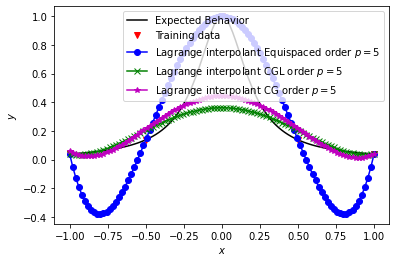

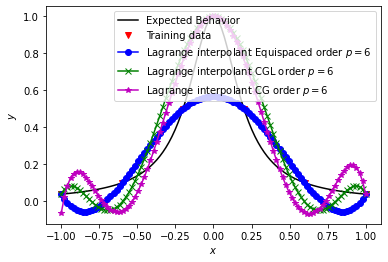

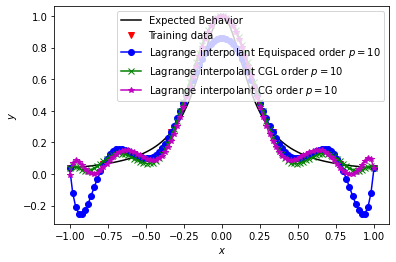

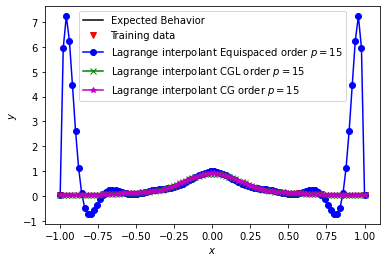

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
  return (1+25.*x**2)**-1

def CGL_points(a,b,n):
  x = np.zeros(n)
  for i in range(n):
    x_hat = -np.cos(np.pi*i/n)
    x[i] = (a+b)/2 + (b-a)/2*x_hat
  return x

def CG_points(a,b,n):
  x = np.zeros(n)
  for i in range(n):
    x_hat = -np.cos(((2*i + 1)/(n+1))*(np.pi/2))
    x[i] = (a+b)/2 + (b-a)/2*x_hat
  return x

N = [5,6,10,15]
a = -1.
b = 1.
for n in N:
    x_CGL = np.zeros((n+1))
    x_CG = np.zeros((n+1))

    # Load training data
    x =  np.linspace(a, b, n)
    y =f(x)

    # Remember you have to add the point x=1, because CGL and CG do not take this
    # point into consideration. 

    x_CGL[:-1] = CGL_points(a,b,n)
    x_CGL[-1] = 1.

    y_CGL = f(x_CGL)
    
    x_CG[:-1] = CG_points(a,b,n)
    x_CG[-1] = 1.
    
    y_CG = f(x_CG)
    
    # Create a grid to plot the predicted function
    x_star = np.linspace(x.min(), x.max(), 100)
    Y = f(x_star)
    # Construct the Lagrange interpolant
    model = LagrangeInterpolant(x_star, x, y)
    y_pred = model.fit()

    model_CGL = LagrangeInterpolant(x_star, x_CGL, y_CGL)
    y_pred_CGL = model_CGL.fit()

    model_CG = LagrangeInterpolant(x_star, x_CG, y_CG)
    y_pred_CG = model_CG.fit()
    
    # Plot the results
    plt.figure()
    #plt.plot(x_v, y_v,'bo', markerfacecolor = 'None', label = "Validation data")
    plt.plot(x_star, Y,'k', label = "Expected Behavior")
    plt.plot(x, y,'rv', label = "Training data")
    plt.plot(x_star, y_pred, 'b-o', label = "Lagrange interpolant Equispaced order $p = %d$"%n)
    plt.plot(x_star, y_pred_CGL, 'g-x', label = "Lagrange interpolant CGL order $p = %d$"%n)
    plt.plot(x_star, y_pred_CG, 'm-*', label = "Lagrange interpolant CG order $p = %d$"%n)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.legend()
    plt.show()


Chebyshev-Gauss-Lobatto and Chebyshev-Gauss points mitigate Runge's phenomenon in a very convenient manner.

# Problem 2

**Euler Method**

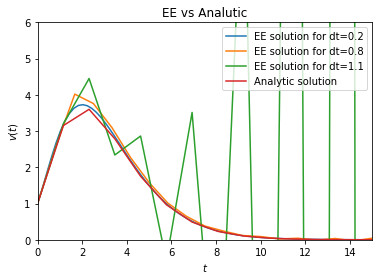

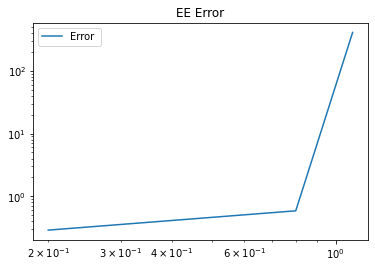

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def func(u,t):
    alpha = (3.*t)/(1+t)
    beta = 2*(1.+t)**3*np.exp(-t)
    return -alpha*u + beta

h_steps =[0.2,0.8,1.1]
error = []
hh = []
fig= plt.figure()

for h in h_steps:
    method = ExplicitEuler(func, 1.0, 1e-05, 15, h)
    x  = method.explicit_euler()
    t = np.linspace(0,15, len(x))
     
    # initial condition
    plt.plot(t,x, label="EE solution for dt=%s"%h)
   
# solve ODE
    
    y = np.exp(-t)*(t+1)**3
    er = np.linalg.norm(x - y, 2)
    error.append(er)
    hh.append(h)

plt.plot(t,y,label="Analytic solution")
plt.xlabel(r'$t$')
plt.ylabel(r'$v(t)$')
plt.title("EE vs Analutic")
plt.xlim(0,15)
plt.ylim(0,6)

plt.legend()

fig= plt.figure()    
plt.loglog(hh, error, label="Error ")
plt.title("EE Error")

plt.legend()
plt.show()



**Trapezoidal Rule**

x_N = 0.001252
x_N = 0.001234
x_N = 0.001206


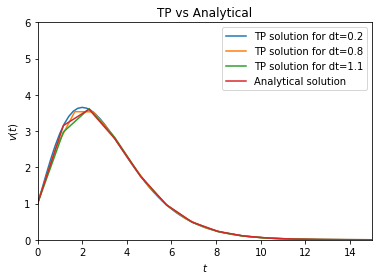

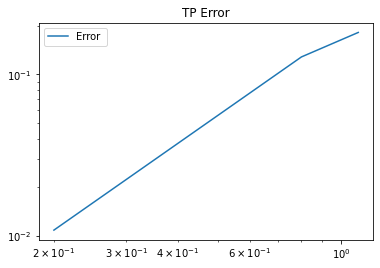

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def func(u,t):
    alpha = (3.*t)/(1+t)
    beta = 2*(1.+t)**3*np.exp(-t)
    return -alpha*u + beta

h_steps =[0.2,0.8,1.1]
error = []
h = []
fig= plt.figure()

for dt in h_steps:
    t_max = 15  
    N = int(t_max/dt)
    y0 = 1.0
    
    t = np.linspace(0, t_max, N+1)
    x = np.zeros(N+1)
    
    # set initial value
    x[0] = 1.0
    
    for n in range(N):
        method = NewtonMethodTrapezoidal(func, dt)
        x[n+1] = method.newton(x[n], t[n+1])
    
    print(r'x_N = %f' % x[-1])
    # solve ODE
    plt.plot(t,x, label="TP solution for dt=%s"%dt)    
    y = np.exp(-t)*(t+1)**3
    er = np.linalg.norm(x - y, 2)
    error.append(er)
    h.append(dt)

plt.plot(t,y,label="Analytical solution")
plt.xlabel(r'$t$')
plt.ylabel(r'$v(t)$')
plt.title("TP vs Analytical")
plt.xlim(0,15)
plt.ylim(0,6)

plt.legend()

fig= plt.figure()    
plt.loglog(h, error, label="Error ")
plt.title("TP Error")

plt.legend()
plt.show()





**Runge-Kutta 4th Order**

0.2
0.8
1.1


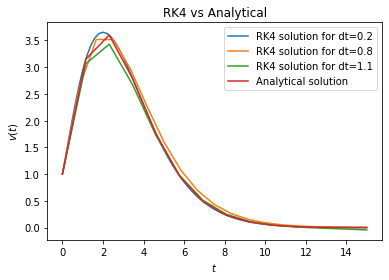

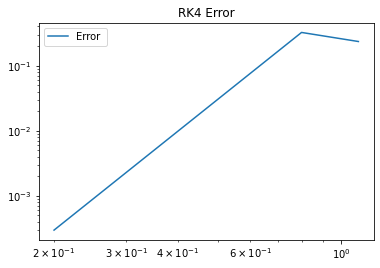

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def func(u,t):
    alpha = (3.*t)/(1+t)
    beta = 2*(1.+t)**3*np.exp(-t)
    return -alpha*u + beta




h_steps =[0.2,0.8,1.1]
error = []
h = []
fig= plt.figure()

for dt in h_steps:
    print(dt)
    method = RungeKutta4(func, 1.0, 0, 15,dt)
    y_sol = method.RK4()
    
    # initial condition
    y0 = 1.0
    
    # time points
    t = np.linspace(0,15, len(y_sol))
    plt.plot(t,y_sol, label="RK4 solution for dt=%s"%dt)
   
# solve ODE
    
    y = np.exp(-t)*(t+1)**3
    er = np.linalg.norm(y_sol - y, 2)
    error.append(er)
    h.append(dt)

plt.plot(t,y,label="Analytical solution")
plt.xlabel(r'$t$')
plt.ylabel(r'$v(t)$')
plt.title("RK4 vs Analytical")
plt.legend()

fig= plt.figure()    
plt.loglog(h, error, label="Error ")
plt.title("RK4 Error")

plt.legend()
plt.show()




We observe that for large time steps the Explicit Euler method is unstable and blows up. The Trapezoidal rule is an implicit method and unconditionally stable, but as the time step increases the accuracy decreases. For the Runge-Kutta method, we observe that despite being an explicit method it is stable for all time steps and also more accurate than TR and EE.

# Problem 3

**First-Order Finite Difference Method**

We start from:

$f_{j+1} = f_j + h f'_j + \frac{ h^2}{2 !} f''_j + \frac{ h^3}{3!} f'''_j + \mathcal{O}(h^4) $

which implies:

$f_{j+1} - f_j = h f'_j + \frac{ h^2}{2 !} f''_j + \frac{ h^3}{3!} f'''_j + \mathcal{O}(h^4)$

or 

$f'_j = \frac{f_{j+1} - f_j}{h}  - \frac{ h}{2 !} f''_j - \frac{ h^2}{3!} f'''_j + \mathcal{O}(h^3)$

or 
$f'_j = \frac{f_{j+1} - f_j}{h} + \mathcal{O}(h)$

Therefore this scheme is first order accurate.

**Second-Order Finite Difference Method**

We start from:

$f_{j+1} = f_j + h f'_j + \frac{ h^2}{2 !} f''_j + \frac{ h^3}{3!} f'''_j + \mathcal{O}(h^4) $ (1)

and 

$f_{j-1} = f_j - h f'_j + \frac{ h^2}{2 !} f''_j - \frac{ h^3}{3!} f'''_j + \mathcal{O}(h^4) $ (2)

(1) - (2) equals:

$f_{j+1} - f_{j-1} = 2h f'_j  + 2\frac{ h^3}{3!} f'''_j + \mathcal{O}(h^4) $

or 

$ f'_j = \frac{f_{j+1} - f_{j-1}}{2h} - \frac{ h^2}{3!} f'''_j + \mathcal{O}(h^3) $

or 

$ f'_j = \frac{f_{j+1} - f_{j-1}}{2h} + \mathcal{O}(h^2) $


Therefore this scheme is second order accurate.

**Fourth-Order Finite Difference Method**

We start from:

$f_{j+1} = f_j + h f'_j + \frac{ h^2}{2 !} f''_j + \frac{ h^3}{3!} f'''_j + \frac{ h^4}{4!} f'''_j + \frac{ h^5}{5!} f'''_j +  \mathcal{O}(h^6) $ 

Multiply by $8$:

$8f_{j+1} = 8f_j + 8h f'_j + 8\frac{ h^2}{2 !} f''_j + 8\frac{ h^3}{3!} f'''_j + 8\frac{ h^4}{4!} f''''_j + 8\frac{ h^5}{5!} f'''''_j +  \mathcal{O}(h^6) $ (1)

Same for $f_{j-1}$

$f_{j-1} = f_j - h f'_j + \frac{ h^2}{2 !} f''_j - \frac{ h^3}{3!} f'''_j + \frac{ h^4}{4!} f''''_j - \frac{ h^5}{5!} f'''''_j +  \mathcal{O}(h^6)$

Multiply by $-8$:

 $-8f_{j-1} = -8f_j + 8h f'_j - 8\frac{ h^2}{2 !} f''_j + 8\frac{ h^3}{3!} f'''_j - 8\frac{ h^4}{4!} f''''_j + 8\frac{ h^5}{5!} f'''''_j +  \mathcal{O}(h^6) $  (2)

also

$f_{j+2} = f_j + 2 h f'_j + \frac{ (2h)^2}{2 !} f''_j + \frac{ (2h)^3}{3!} f'''_j + \frac{ (2h)^4}{4!} f''''_j + + \frac{ (2h)^5}{5!} f'''''_j +  \mathcal{O}(h^6) $ 

Multiply by $-1$:

$-f_{j+2} = -f_j - 2 h f'_j - \frac{ (2h)^2}{2 !} f''_j - \frac{ (2h)^3}{3!} f'''_j - \frac{ (2h)^4}{4!} f''''_j - \frac{ (2h)^5}{5!} f'''''_j +  \mathcal{O}(h^6) $ (3)

and

$f_{j-2} = f_j - 2 h f'_j + \frac{ (2h)^2}{2 !} f''_j - \frac{ (2h)^3}{3!} f'''_j + \frac{ (2h)^4}{4!} f''''_j - \frac{ (2h)^5}{5!} f'''''_j +  \mathcal{O}(h^6) $ (4)




(1) + (2) + (3) + (4) equals:

$ f'_j = \frac{f_{j−2} − 8 f_{j−1} + 8 f_{j+1} − f_{j+2}}{12 h} +  8 \frac{ h^4}{5!} f'''''_j +  \mathcal{O}(h^5)$ 

or 

$ f'_j = \frac{f_{j−2} − 8 f_{j−1} + 8 f_{j+1} − f_{j+2}}{12 h} + \mathcal{O}(h^4)$ 

Therefore this scheme is fourth order accurate.

Experimentally predicted accuracy CD2: 1.998372e+00
Experimentally predicted accuracy CD4: 3.987738e+00


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Experimentally predicted accuracy FD1: 9.979537e-01


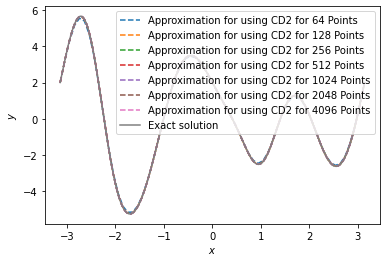

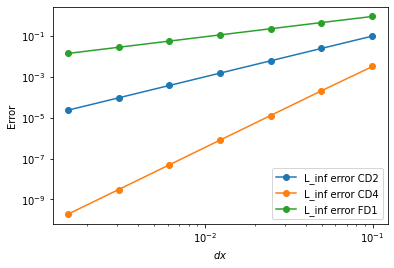

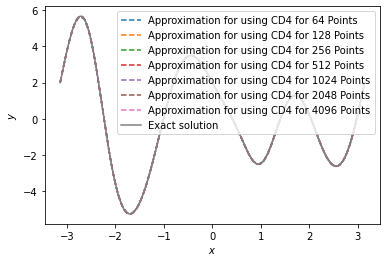

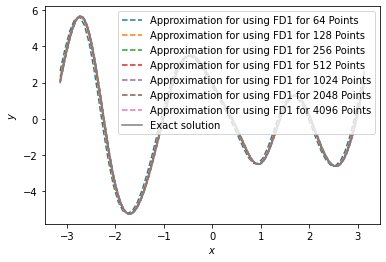

In [ ]:
import autograd.numpy as np
from autograd import elementwise_grad as egrad
import matplotlib.pyplot as plt
                    
from scipy.stats import linregress

                    
from scipy.stats import linregress

if __name__ == '__main__':
    
    def f(x):
        return np.cos(3.*x) + np.exp(np.sin(2.*x))
    
    N = np.array([64, 128, 256,512,1024, 2048, 4096])
    
    lb = -np.pi
    ub =  np.pi
    grad_f = egrad(f)
    
    name = [CentralDifferenceSecondOrder, CentralDifferenceForthOrder, ForwardDifferenceFirstOrder]
    
    for counter,name in enumerate(name):
        pred = []
        x_grid = []
        dx_a = np.zeros((N.shape[0],1))
        error = np.zeros((N.shape[0],1))
    
        for i in range(0, N.shape[0]):
            # Fit a central difference approximation        
            model = name(f, lb, ub, N[i])
            df_dx_pred, dx = model.compute()
            
            pred.append(df_dx_pred)
        
            # Create a grid for testing the accuracy
            x_star = np.linspace(lb, ub, N[i])[:,None]
            y_star = grad_f(x_star)
            e = np.linalg.norm(y_star - pred[i], np.inf)
            error[i,0] = e
            x_grid.append(x_star)
            dx_a[i,0] = dx[0]
            
            
        slope, intercept, rvalue, pvalue, stderr = linregress(np.log(dx_a[:,-1]), np.log(error[:,-1]))
                
        # Plot
        if name == CentralDifferenceSecondOrder:
            lab = "CD2"
            print("Experimentally predicted accuracy %s: %e"%(lab, slope))
        if name == CentralDifferenceForthOrder:
            lab = "CD4"
            print("Experimentally predicted accuracy %s: %e"%(lab, slope))

        if name == ForwardDifferenceFirstOrder:
            lab = "FD1"
            print("Experimentally predicted accuracy %s: %e"%(lab, slope))
            
        fig = plt.figure(counter)
        ax1 = fig.add_subplot(1, 1, 1)
        for i in range(0, N.shape[0]):
            n = N[i]
            ax1.plot(x_grid[i], pred[i], '--',  label = "Approximation for using %s for %d Points"%(lab,n))
        ax1.plot(x_grid[-1], grad_f(x_grid[-1]), '-', label = "Exact solution")

        ax1.set_xlabel('$x$')
        ax1.set_ylabel('$y$')
        plt.legend()
        
        fig = plt.figure(12)
        ax2 = fig.add_subplot(1,1, 1)
        ax2.plot(dx_a, error, 'o-', label = "L_inf error %s"%lab)
        ax2.set_xlabel('$dx$')
        ax2.set_ylabel('Error')
        ax2.set_xscale('log')
        ax2.set_yscale('log')
        plt.legend()



By calculating the slopes in the error-dx figures we get the experimental veryfication of the accuracy of each scheme.